# The local unitary cluster Jastrow (LUCJ) ansatz

This page explains the local unitary cluster Jastrow (LUCJ) ansatz, which was originally introduced in [this paper](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k). For a guide on simulating the LUCJ ansatz using ffsim, see [How to simulate the local unitary cluster Jastrow (LUCJ) ansatz](../how-to-guides/simulate-lucj.ipynb).

## The general unitary cluster Jastrow (UCJ) ansatz

The LUCJ ansatz is a specialized form of the general unitary cluster Jastrow (UCJ) ansatz, which has the form

$$
  \lvert \Psi \rangle = \prod_{k = 1}^L \mathcal{U}_k e^{i \mathcal{J}_k} \mathcal{U}_k^\dagger \lvert \Phi_0 \rangle
$$

where $\lvert \Phi_0 \rangle$ is a reference state, often taken as the Hartree-Fock state, each $\mathcal{U}_k$ is an [orbital rotation](orbital-rotation.ipynb), and each $\mathcal{J}_k$ is a diagonal Coulomb operator of the form

$$
    \mathcal{J} = \frac12\sum_{ij,\sigma \tau} \mathbf{J}^{\sigma \tau}_{ij} n_{i,\sigma} n_{j,\tau}.
$$

In ffsim, the UCJ ansatz is represented using classes that store the diagonal Coulomb matrices and orbital rotations as Numpy arrays. To facilitate variational optimization of the ansatzes, these classes implement methods for conversion to and from a vector of real-valued parameters. The parameter vector stores the entries of the UCJ matrices in a non-redundant way (for the orbital rotations, the parameter vector actually stores the entries of their logarithm).

### Spin-balanced and spin-unbalanced ansatzes

ffsim implements two variants of the UCJ ansatz, a "spin-balanced" ansatz, which is appropriate to apply to a closed-shell reference state, and a "spin-unbalanced" ansatz, which is appropriate to apply to an open-shell initial reference state.

In the spin-balanced ansatz, $\mathbf{J}^{\alpha\alpha} = \mathbf{J}^{\beta\beta}$ and $\mathbf{J}^{\alpha\beta} = \mathbf{J}^{\beta\alpha}$. As a result, each diagonal Coulomb operator is described by 2 matrices, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$, and both of these matrices are symmetric. The spin-balanced UCJ ansatz is represented by the [UCJOpSpinBalanced](../api/ffsim.rst#ffsim.UCJOpSpinBalanced) class.

In the spin-unbalanced ansatz, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\beta\beta}$ are allowed to differ, and $\mathbf{J}^{\alpha\beta}$ is no longer required to be symmetric. Since $\mathbf{J}^{\alpha\beta}_{ij} = \mathbf{J}^{\beta\alpha}_{ji}$, we don't need to store $\mathbf{J}^{\beta\alpha}$ separately. Therefore, each diagonal Coulomb operator is described by 3 matrices, $\mathbf{J}^{\alpha\alpha}$, $\mathbf{J}^{\alpha\beta}$, and $\mathbf{J}^{\beta\beta}$, and of these matrices, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\beta\beta}$ are symmetric. The spin-unbalanced UCJ ansatz is represented by the [UCJOpSpinUnbalanced](../api/ffsim.rst#ffsim.UCJOpSpinUnbalanced) class.

## The local UCJ (LUCJ) ansatz

Implementing the $e^{i \mathcal{J}_k}$ term of the UCJ ansatz requires either all-to-all connectivity or the use of a fermionic swap network, making it challenging for noisy pre-fault-tolerant quantum processors that have limited connectivity. The idea of the *local* UCJ ansatz is to impose sparsity constraints on the $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$ matrices which allow them to be implemented in constant depth on qubit topologies with limited connectivity. The constraints are specified by a list of indices indicating which matrix entries in the upper triangle are allowed to be nonzero (since the matrices are symmetric, only the upper triangle needs to be specified). These indices can be interpreted as pairs of orbitals that are allowed to interact.

As an example, consider a square lattice qubit topology. We can place the $\alpha$ and $\beta$ orbitals in parallel lines on the lattice, with connections between these lines forming "rungs" of a ladder shape, like this:

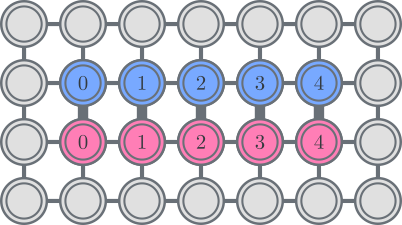

With this setup, orbitals with the same spin are connected with a line topology, while orbitals with different spins are connected when they share the same spatial orbital. This yields the following index constraints on the $\mathbf{J}$ matrices:

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, \ldots, N-1}
\end{align*}
$$

In other words, if the $\mathbf{J}$ matrices are nonzero only at the specified indices in the upper triangle, then the $e^{i \mathcal{J}_k}$ term can be implemented on a square topology without using any swap gates, in constant depth. Of course, imposing such constraints on the ansatz makes it less expressive, so more ansatz repetitions may be required.



## Initialize the LUCJ Ansatz from CCSD t2 Amplitudes

The UCJ ansatz is inspired by the coupled-cluster method. Coupled Cluster Singles and Doubles (CCSD) is a classical method that expresses the wave function as 
$$
\lvert \Psi_\text{CCSD} \rangle = e^{T_1 + T_2}\lvert \Phi_0 \rangle,
$$
where $T_1$ and $T_2$ are the single and double eexcitatoin operators defined as 
$$
T_1 = \sum_{ia} t^i_a \hat{c}^\dagger_i \hat{c}_a,\ 
T_2 = \sum_{ijab} t^{ij}_{ab} \hat{c}^\dagger_i \hat{c}^\dagger_j \hat{c}_a \hat{c}_b.
$$
To efficiently implement coupled-cluster methods on quantum hardware, unitary Coupled Cluster Singles and Doubles (UCCSD) with the unitary operator $e^{(T-T^\dagger)}$ are proposed. 
Through [double-factorization](double-factorized.ipynb), these amplitudes are expressed in the Jastrow form, where diagonal Coulomb operators $\mathcal{J}$ are sandwiched between [orbital rotations](orbital-rotation.ipynb) $\mathcal{U}$:
$$
  T_2 = \sum_{\mu}^L \mathcal{U}_\mu \mathcal{J}_\mu \mathcal{U}_\mu^\dagger.
$$
Because of the physical motivation of UCJ, it is natural to initialize UCJ using the orbital rotations and diagonal Coulomb operators obtained from double-factorization. 

The following code demonstrates the comparison of the potential energy surface of $\text{N}_2$ (with a sto-6g basis) of CCSD, UCCSD, and UCJ. 

converged SCF energy = -108.236212498988
converged SCF energy = -108.375222344891
converged SCF energy = -108.464957764796
converged SCF energy = -108.517607022242
converged SCF energy = -108.542471308893
converged SCF energy = -108.546661436001
converged SCF energy = -108.535614528761
converged SCF energy = -108.513482793822
converged SCF energy = -108.483430129217
converged SCF energy = -108.447860831556
converged SCF energy = -108.408596895667
converged SCF energy = -108.367015444265
converged SCF energy = -108.324154785276
converged SCF energy = -108.280795721587
converged SCF energy = -108.237523481576
converged SCF energy = -108.194774664909
converged SCF energy = -108.152872753473
converged SCF energy = -108.112054982477
converged SCF energy = -108.072492712453
converged SCF energy = -108.034306905921
converged SCF energy = -107.997579896344
converged SCF energy = -107.962364329445
converged SCF energy = -107.928689936689
converged SCF energy = -107.896568644259
converged SCF en

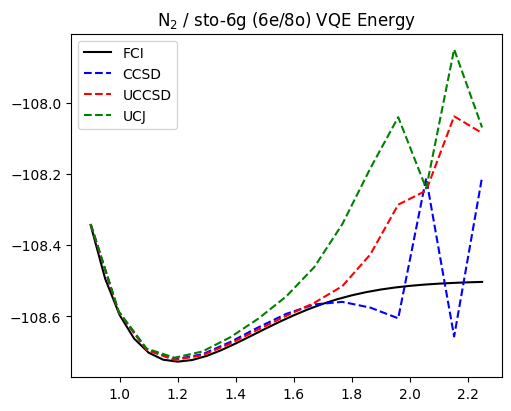

In [1]:
# FCI
import pyscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt
start = 0.9
stop = 2.25
step = 0.1
bond_distance_range = np.linspace(start, stop, num=round((stop - start) / step) + 1)

reference_bond_distance_range = np.linspace(
    start, stop, num=round((stop - start) / 0.05) + 1
)

# FCI
fci_energy = []
for bond_distance in reference_bond_distance_range:
    # Build N2 molecule
    atom = [("N", (-0.5 * bond_distance, 0, 0)), ("N", (0.5 * bond_distance, 0, 0))]
    mol = pyscf.gto.Mole()
    mol.build(
        atom=atom,
        basis="sto-6g",
        symmetry="Dooh",
    )

    # Define active space
    n_frozen = 2
    active_space = range(n_frozen, mol.nao_nr())

    # Get molecular data and Hamiltonian
    scf = pyscf.scf.RHF(mol).run()
    cisolver = pyscf.fci.FCI(scf)
    fci_energy.append(cisolver.kernel()[0])

ccsd_energy = []
uccsd_energy = []
ucj_energy = []
for bond_distance in bond_distance_range:
    # Build N2 molecule
    atom = [("N", (-0.5 * bond_distance, 0, 0)), ("N", (0.5 * bond_distance, 0, 0))]
    mol = pyscf.gto.Mole()
    mol.build(
        atom=atom,
        basis="sto-6g",
        symmetry="Dooh",
    )

    # Define active space
    n_frozen = 2
    active_space = range(n_frozen, mol.nao_nr())

    # Get molecular data and Hamiltonian
    scf = pyscf.scf.RHF(mol).run()
    mol_data = ffsim.MolecularData.from_scf(scf, active_space=active_space)
    norb, nelec = mol_data.norb, mol_data.nelec
    mol_hamiltonian = mol_data.hamiltonian

    # run CCSD
    ccsd = pyscf.cc.CCSD(
        scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
    ).run()
    ccsd_energy.append(ccsd.e_tot)

    t2 = ccsd.t2
    t1 = ccsd.t1

    # run UCCSD
    # Initialize initial state
    hamiltonian = ffsim.linear_operator(mol_hamiltonian, norb=norb, nelec=nelec)
    reference_state = ffsim.hartree_fock_state(norb, nelec)

    # use CCSD to initialize parameters
    operator = ffsim.UCCSDOpRestrictedReal(t1=t1, t2=t2)

    # Compute final state
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)

    # record vqe energy
    energy = np.vdot(final_state, hamiltonian @ final_state).real
    uccsd_energy.append(energy)

    # run UCJ
    operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2,
        t1=t1,
    )
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)
    energy = np.vdot(final_state, hamiltonian @ final_state).real
    ucj_energy.append(energy)

# plot energy
fig = plt.figure(figsize=(5, 4), layout="constrained")
plt.plot(
    reference_bond_distance_range,
    fci_energy,
    "-",
    label="FCI",
    color="black",
)
plt.plot(
    bond_distance_range,
    ccsd_energy,
    "--",
    label="CCSD",
    color="blue",
)
plt.plot(
    bond_distance_range,
    uccsd_energy,
    "--",
    label="UCCSD",
    color="red",
)
plt.plot(
    bond_distance_range,
    ucj_energy,
    "--",
    label="UCJ",
    color="green",
)
plt.title("N$_2$ / sto-6g (6e/8o) VQE Energy")
plt.legend()
plt.show()

According to the plot, CCSD t2 amplitudes provide good initial paramters for the UCJ ansatz. However, LUCJ anstaz requires truncating the interaction terms. In addition, when implementing on the pre-fault-tolerant quantum processors, we often need to limit the number of layers, which introduces more errors due to reduced circuit expressiveness. 

The following code demonstrates the truncation errors caused by 1. limited connectivity by comparing the UCJ ansatz and LUCJ ansatz with square connectivity, 2. limited circuit depth by comparing the ansatzes with different numbers of layers (x-axis).

converged SCF energy = -108.535614528761
E(CCSD) = -108.7208078628675  E_corr = -0.1851933341064035


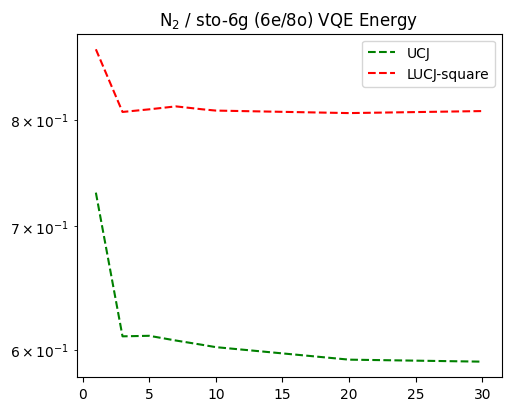

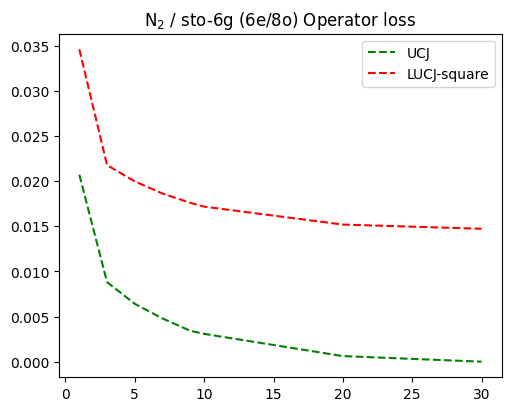

In [20]:
# Build N2 molecule with R=1.2Å
atom = [("N", (-0.6, 0, 0)), ("N", (0.6, 0, 0))]
mol = pyscf.gto.Mole()
mol.build(
    atom=atom,
    basis="sto-6g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular data and Hamiltonian
scf = pyscf.scf.RHF(mol).run()
mol_data = ffsim.MolecularData.from_scf(scf, active_space=active_space)
norb, nelec = mol_data.norb, mol_data.nelec
mol_hamiltonian = mol_data.hamiltonian

# run CCSD
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
ccsd_energy.append(ccsd.e_tot)

t2 = ccsd.t2
t1 = ccsd.t1


reference_state = ffsim.hartree_fock_state(norb, nelec)

# Use interactions implementable on a square lattice
pairs_aa = [(p, p + 1) for p in range(norb - 1)]
pairs_ab = [(p, p) for p in range(norb)]

# fci energy reference
cisolver = pyscf.fci.FCI(scf)
fci_energy_reference = cisolver.kernel()[0]

operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2,
        t1=t1,
    )

# function to compute the difference with the original t2 amplitude
# with a least-squares objective function.
def loss(op, interaction_pairs = None):
    nocc, _, _, _ = t2.shape
    orbital_rotations = op.orbital_rotations
    diag_coulomb_mats = np.zeros(orbital_rotations.shape)
    if interaction_pairs is not None:
        pairs_aa, pairs_ab = interaction_pairs
        rows, cols = zip(*pairs_aa)
        diag_coulomb_mats[:, rows, cols] = op.diag_coulomb_mats[:, 0, rows, cols]
        diag_coulomb_mats[:, cols, rows] = op.diag_coulomb_mats[:, 0, rows, cols]
        rows, cols = zip(*pairs_ab)
        diag_coulomb_mats[:, rows, cols] = op.diag_coulomb_mats[:, 1, rows, cols]
        diag_coulomb_mats[:, cols, rows] = op.diag_coulomb_mats[:, 1, rows, cols]
    else:
        diag_coulomb_mats = op.diag_coulomb_mats[:, 0]

    reconstructed = (
        1j
        * np.einsum(
            "mpq,map,mip,mbq,mjq->ijab",
            diag_coulomb_mats,
            orbital_rotations,
            orbital_rotations.conj(),
            orbital_rotations,
            orbital_rotations.conj(),
            optimize="greedy",
        )[:nocc, :nocc, nocc:, nocc:]
    )
    diff = reconstructed - t2
    return 0.5 * np.sum(np.abs(diff) ** 2)

ucj_energy_error = []
lucj_energy_error = []
ucj_loss = []
lucj_loss = []
n_reps_range = list(range(1, 10, 2)) + [10, 20, 30]
for n_reps in n_reps_range:
    # run UCJ
    # use CCSD to initialize parameters
    operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2,
        t1=t1,
        n_reps=n_reps
    )
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)
    energy = np.vdot(final_state, hamiltonian @ final_state).real
    ucj_energy_error.append(energy - fci_energy_reference)
    ucj_loss.append(loss(operator))

    # run LUCJ
    operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2,
        t1=t1,
        n_reps=n_reps,
        interaction_pairs=(pairs_aa, pairs_ab)
    )
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)
    energy = np.vdot(final_state, hamiltonian @ final_state).real
    lucj_energy_error.append(energy - fci_energy_reference)
    lucj_loss.append(loss(operator, (pairs_aa, pairs_ab)))

# plot energy
fig = plt.figure(figsize=(5, 4), layout="constrained")
plt.plot(
    n_reps_range,
    ucj_energy_error,
    "--",
    label="UCJ",
    color="green",
)
plt.plot(
    n_reps_range,
    lucj_energy_error,
    "--",
    label="LUCJ-square",
    color="red",
)
plt.title("N$_2$ / sto-6g (6e/8o) VQE Energy")
plt.legend()
plt.yscale("log")
plt.show()

# plot loss
fig = plt.figure(figsize=(5, 4), layout="constrained")
plt.plot(
    n_reps_range,
    ucj_loss,
    "--",
    label="UCJ",
    color="green",
)
plt.plot(
    n_reps_range,
    lucj_loss,
    "--",
    label="LUCJ-square",
    color="red",
)
plt.title("N$_2$ / sto-6g (6e/8o) Operator loss")
plt.legend()
plt.show()

As shown in the figure, these truncations increase operator loss and energy error. As the circuits lack sufficient terms to fully capture interaction, the resulting wavefunctions are overly concentrated around the Hartree-Fock state. To mitigate this, we can "compress" the t2 amplitudes to fit within the desired circuit depth and connectivity by optimizing the coefficients of the remaining operators to recover the original t2 amplitudes with a least sqaures loss function
$$
||T_2-\bar{T_2}||_2,
$$
where $\bar{T_2}$ is reconstructed by the comprressed operator according to the relation 
$$
\bar{t}_{ijab} = \sum_k\sum_{pq} J^k_{pq} U^k_{ap} U^{k*}_{ip}U^k_{nq} U^{k*}_{iq}.
$$

The following code demonstrates that the compression techqnique can effectively recover the original amplitudes by reducing operator loss and thus improve the energy. Note that to improve VQE energy, regularization for the operator norm is important to mitigate the increase of the Trotterization error due to large operator norm:
$$
\lambda\cdot(\sum_{k=1}^L||\bar{J}||_2-\sum_{k=1}^N||J||_2).
$$

In [ ]:
lucj_compressed_energy_error = []
lucj_compressed_loss = []
n_reps_range = list(range(1, 10, 2)) + [10, 20, 30]
for n_reps in n_reps_range:
    # use CCSD to initialize parameters
    # run LUCJ
    operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2,
        t1=t1,
        n_reps=n_reps,
        interaction_pairs=(pairs_aa, pairs_ab),
        optimize=True, # enable compression
        regularization=1e-3 
    )
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)
    energy = np.vdot(final_state, hamiltonian @ final_state).real
    lucj_compressed_energy_error.append(energy - fci_energy_reference)
    lucj_compressed_loss.append(loss(operator, (pairs_aa, pairs_ab)))

# plot energy
fig = plt.figure(figsize=(5, 4), layout="constrained")
plt.plot(
    n_reps_range,
    ucj_energy_error,
    "--",
    label="UCJ",
    color="green",
)
plt.plot(
    n_reps_range,
    lucj_energy_error,
    "--",
    label="LUCJ-square",
    color="red",
)
plt.plot(
    n_reps_range,
    lucj_compressed_energy_error,
    "--",
    label="LUCJ-compressed",
    color="blue",
)
plt.title("N$_2$ / sto-6g (6e/8o) VQE Energy")
plt.legend()
plt.yscale("log")
plt.show()


# plot loss
# plot loss
fig = plt.figure(figsize=(5, 4), layout="constrained")
plt.plot(
    n_reps_range,
    ucj_loss,
    "--",
    label="UCJ",
    color="green",
)
plt.plot(
    n_reps_range,
    lucj_loss,
    "--",
    label="LUCJ-square",
    color="red",
)
plt.plot(
    n_reps_range,
    lucj_compressed_loss,
    "--",
    label="LUCJ-compressed",
    color="blue",
)
plt.title("N$_2$ / sto-6g (6e/8o) VQE Energy")
plt.legend()
plt.show()

TypeError: UCJOpSpinBalanced.from_t_amplitudes() got an unexpected keyword argument 'optimize'